In [1]:
from collections import defaultdict, Counter, deque, OrderedDict
from intervaltree import Interval, IntervalTree
import itertools
import functools
import heapq
import math
import numpy as np
import networkx as nx
import re
from typing import Callable, TypeVar

np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))

T = TypeVar('T')

def data(day: int, parser: Callable[[str], T] = str) -> list[T]:
  with open(f"./data/day{day}.txt") as f:
    return [parser(line.strip()) for line in f.readlines()]

In [9]:
def dfs(nodes, start, get_neighbors, end_condition=lambda _: False):
    q, visited = deque([(start, 0)]), {}
    while q:
        current, distance = q.popleft()
        if end_condition(current):
            return visited, current
        if current in visited:
            continue
        for node in get_neighbors(nodes, current):
            q.append((node, distance+1))
        visited[current] = distance
    return visited, None

def visualize(arr, vmap):
    visual = arr.copy()
    for x, y in vmap:
        visual[y, x] = vmap[(x, y)]
    print(visual)


def dijkstra(
    nodes, 
    start, 
    get_neighbors, 
    end_condition=lambda _: False, 
):
    q, visited = start, {}
    while q:
        distance, current = heapq.heappop(q)
        if str(current) in visited:
            continue
        visited[str(current)] = distance
        if end_condition(current):
            return visited, current
        for node in get_neighbors(nodes, current, distance):
            heapq.heappush(q, node)
    return visited, None


In [ ]:
data1 = data(1)

def day1(match):
    sum = 0
    for line in data1:
        matched = match(line)
        first, last = matched[0], matched[-1]
        # print(first, last, sum)
        sum += int(first + last)
    return sum

def part2match(x):
    change = {
        'one': '1',
        'two': '2',
        'three': '3',
        'four': '4',
        'five': '5',
        'six': '6',
        'seven': '7',
        'eight': '8',
        'nine': '9',
    }
    matched = re.findall(r'(?=(\d|one|two|three|four|five|six|seven|eight|nine))', x)
    return [change[match] if match in change else match for match in matched]

day1(lambda x: re.findall(r'\d', x)), day1(part2match)

In [ ]:
def format2(line):
    def tuplefy(round):
        result = [0,0,0]
        for i in round:
            result[0 if 'blue' in i else 1 if 'green' in i else 2] += int(i.split(' ')[0])
        return result

    line = line.split(': ')[-1]
    rounds = line.split('; ' )
    return np.array([tuplefy(x.split(', ')) for x in rounds])

data2 = data(2, format2)

def day2_1(start):
    result = 0
    for i, game in enumerate(data2):
        possible = np.subtract(start, game)
        if np.any(possible < 0):
            continue
        result += i+1
    return result

def day2_2():
    result = 0
    for game in data2:
        requirements = np.amax(game, axis=0)
        result += functools.reduce(lambda x, y: x*y, requirements, 1)
    return result

day2_1((14, 13, 12)), day2_2()

In [ ]:
data3 = data(3)

def day3():
    numbers = []
    for i, line in enumerate(data3):
        numbers += [(m.group(), (i, m.start())) for m in re.finditer(r'\d+', line)]

    array3 = np.pad(np.array([list(line) for line in data3]), ((1, 1), (1, 1)), constant_values='.')
    gears = defaultdict(lambda: [])

    part1 = 0
    for n, (i, j) in numbers:
        sliced = array3[i:i+3, j:j+2+len(n)]
        stringified =  ''.join(''.join(x) for x in sliced)
        if re.search(r'[^\d.]', stringified):
            part1 += int(n)
        if stars := np.where(sliced == '*'):
            for x, _ in enumerate(stars[0]):
                gears[(i+stars[0][x], j+stars[1][x])].append(int(n))

    part2 = 0
    for g in gears:
        if len(gears[g]) == 2:
            part2 += gears[g][0] * gears[g][1]

    return part1, part2

day3()

In [ ]:
def parse4(line):
    winning, have = map(
        lambda numbers: {int(x) for x in numbers.split()},
        line.split(':')[-1].split('|')
    )
    return winning, have

data4 = data(4, parse4)

def day4(data):
    result, cards = 0, Counter()
    for i, line in enumerate(data):
        matches = line[0].intersection(line[1])
        if matches:
            result += 2**(len(matches)-1)
        for n in range(len(matches)):
            cards[i+1+n] += cards[i]+1
    return result, cards.total() + len(data)

day4(data4)

In [ ]:
debug=False

def day5_maps(data):
    names, maps = [], []

    def create_map(lines):
        ranges = IntervalTree([Interval(0, math.inf)])
        name = lines[0].split()[0]
        for i, line in enumerate(lines[1:]):
            if not line:
                break
            dest, source, size = map(int, line.split())
            ranges.chop(source, source+size)
            ranges[source:source+size] = dest
        return name, ranges, lines[i+2:]

    seeds, data = map(int, data[0].split(': ')[-1].split()), data[2:]

    while len(data):
        name, intervals, data = create_map(data)
        names.append(name)
        maps.append(intervals)

    return list(seeds), maps, names

seeds, intervals, names = day5_maps(data(5))

def day5_1(seeds, data):
    lowest = math.inf
    for seed in seeds:
        for interval in data:
            start, end, dest = next(iter(interval.at(seed)))
            seed = seed if dest is None else (seed-start)+dest
        lowest = min(lowest, seed)
    return lowest

def day5_2(seeds, data):
    seedrange = IntervalTree([Interval(start, start+size) for start, size in zip(seeds[::2], seeds[1::2])])
    seedrange.merge_overlaps()

    for i, interval in enumerate(data):
        newrange = IntervalTree()
        if debug:
            print(names[i], seedrange, interval)
        for (seedstart, seedend, _) in seedrange:
            intersections = interval[seedstart:seedend]
            for (start, end, dest) in intersections:
                newstart = (dest + max(seedstart, start)-start) if dest is not None else seedstart
                newend = (dest + min(seedend, end)-start) if dest is not None else seedend
                newrange.addi(newstart, newend)
        newrange.merge_overlaps()
        seedrange = newrange
        
    lowest = min([loc[0] for loc in seedrange])
    return lowest

day5_1(seeds, intervals), day5_2(seeds, intervals)


In [ ]:
data6 = data(6, lambda x: list(map(int, x.split(':')[-1].split())))

def day6(times, distances):
    result = []
    for t, d in zip(times, distances):
        # (t-x)*x = d+1
        # -x**2 +xt -d-1 = 0
        a, b, c = -1, t, -d-1
        det = math.sqrt(b**2 - 4*a*c)
        if det < 0:
            continue
        zeros = (-b+det)/(2*a), (-b-det)/(2*a)
        floor, ceil = math.ceil(min(zeros)), math.floor(max(zeros))
        result.append(ceil-floor+1)
    return functools.reduce(lambda x, y: x*y, result, 1)

day6(*data6), day6(*[[int(''.join(map(str, x)))] for x in data6])

In [ ]:
data7 = data(7, lambda x: x.split())

def card_ord(card, flag=False):
    match card:
        case 'T': return 10
        case 'J': return 1 if flag else 11
        case 'Q': return 12
        case 'K': return 13
        case 'A': return 14
    return int(card)

def score_hand(hand, flag=False):
    cards = [card_ord(card, flag) for card in hand]
    if flag:
        filtered = Counter(hand.replace('J', ''))
        hand = hand.replace('J', filtered.most_common(1)[0][0] if filtered else 'A')

    counts = Counter(hand)
    score = sum([counts[x]**2 for x in counts])
    return [score]+cards

def day7(data, flag=False):
    key = lambda x: score_hand(x[0], flag)
    ordered = sorted(data, key=key)
    return sum((i+1)*int(score) for i, (_, score) in enumerate(ordered))

day7(data7), day7(data7, True)

In [ ]:
def parse8(data):
    instructions, nodes = data[0], {}
    for line in data[2:]:
        start, l, r = re.findall(r'(.{3}) = \((.{3}), (.{3})\)', line)[0] 
        nodes[start] = (l, r)
    return instructions, nodes

data8 = parse8(data(8))

def day8(instructions, nodes, start, ends):
    count, node = 0, start
    for i in itertools.cycle(instructions):
        node = nodes[node][0 if i == 'L' else 1]
        count +=1
        if ends(node):
            break
    return count

def day8_2(instructions, nodes):
    results = []
    for start in filter(lambda x: re.match(r'..A', x), nodes):
        results.append(day8(instructions, nodes, start, lambda x: re.match(r'..Z', x)))
    return math.lcm(*results)

day8(*data8, 'AAA', lambda x: x == 'ZZZ'), day8_2(*data8)

In [43]:
data9 = data(9, lambda line: [int(x) for x in line.split()])

def determine_steps(arr, i=-1):
    steps = [arr[i]]
    while len(np.unique(arr)) > 1:
        arr = np.diff(arr)
        steps.append(arr[i])
    return steps

def day9(data, part2=False):
    part1, part2 = 0, 0
    for history in data:
        steps = determine_steps(np.array(history)), determine_steps(np.array(history), 0)
        part1 += sum(steps[0])
        part2 += sum(steps[1][::2]) - sum(steps[1][1::2])
    return part1, part2

day9(data9)

(2008960228, 1097)

In [ ]:
data10 = np.array(data(10, list))

pipe_map = {
    '|': [(0, -1), (0, 1)],
    '-': [(-1, 0), (1, 0)],
    'L': [(0, -1), (1, 0)],
    'J': [(0, -1), (-1, 0)],
    '7': [(0, 1), (-1, 0)],
    'F': [(0, 1), (1, 0)],
}

def pipe_neighbors(pipe, x, y):
    if pipe not in pipe_map:
        return
    for i in pipe_map[pipe]:
        yield (x+i[0], y+i[1])

def get_neighbors(x, y):
    return [(x-1, y), (x+1, y), (x, y+1), (x, y-1)]

def fix_pipe_start(arr):    
    start_coords = np.where(arr == 'S')
    y, x = start_coords[0][0], start_coords[1][0]

    neighbors = []
    for i, j in get_neighbors(x, y):
        if (x, y) in pipe_neighbors(data10[j, i], i, j):
            neighbors.append((i-x, j-y))
    for pipe in pipe_map.keys():
        if frozenset(pipe_map[pipe]) == frozenset(neighbors):
            arr[y, x] = pipe
    return x, y

def day10_1(data):
    arr = data.copy()
    start = fix_pipe_start(arr)
    visited, _ = dfs(data, start, lambda _, coords: pipe_neighbors(arr[coords[1], coords[0]], *coords))
    # visualize(arr, visited)
    return visited

def day10(data):
    visited = day10_1(data)

    claimed = {}
    for y, row in enumerate(data):
        inside = False
        for x, pipe in enumerate(row):
            if (x, y) in visited:
                if pipe in 'LJ|':
                    # If pipe is part of path and is north: taken from https://old.reddit.com/r/adventofcode/comments/18fgddy/2023_day_10_part_2_using_a_rendering_algorithm_to/
                    inside ^= True 
            elif inside:
                claimed[(x, y)] = 'I'
    # visualize(data, claimed)

    return max(visited.values()), len(claimed)

day10(data10)


In [ ]:
data11 = np.array(data(11, list))

def day11(data, expansions):
    cols, rows = [IntervalTree([Interval(x, x+1) for x in np.where(np.all(data == '.', axis=i))[0]]) for i in range(2)]

    galaxies = np.where(data == '#')

    results = Counter()
    for a, b in itertools.combinations(range(len(galaxies[0])), 2):
        xs, ys = Interval(galaxies[0][a], galaxies[0][b]), Interval(*sorted([galaxies[1][a], galaxies[1][b]]))
        empties = len(cols[ys[0]:ys[1]]) + len(rows[xs[0]:xs[1]])
        distance = ys[1]-ys[0] + xs[1]-xs[0]
        for expansion in expansions:
            results[expansion] += distance + empties * (expansion-1)
    return results

day11(data11, [2, 1000000])

In [ ]:
def parse12(line):
    springs, conditions = line.split(' ')
    return springs, tuple(map(int, conditions.split(',')))

data12 = data(12, parse12)

@functools.lru_cache()
def fix_records(line, numbers, active=0):
    if not numbers:
        return 0 if '#' in line else 1
    if not line:
        return 0
    n, nt = numbers[0], numbers[1:]
    head, tail = line[0], line[1:]
    if head == '.':
        if active:
            if n > 0:
                return 0
            return fix_records(tail, nt)
        return fix_records(tail, numbers)
    elif head == '#':
        if n == 0:
            return 0
        return fix_records(tail, (n-1, *nt), active+1)
    else:
        return fix_records('.'+tail, numbers, active) + fix_records('#'+tail, numbers, active)

def sum_records(data, n=1):
    result = 0
    for spring, numbers in data:
        result += fix_records('?'.join([spring]*n) + '.', numbers*n)
        # print(spring*n, numbers*n, result)
    return result

def day12(data):
    return sum_records(data), sum_records(data, 5)

day12(data12)

In [ ]:
def parse13(lines):
    result = []
    for i, line in enumerate(lines):
        line = line.strip()
        if not line:
            return result, lines[i+1:]
        else:
            result.append(list(map(int, line.replace('.', '0').replace('#', '1'))))
    return result, []

def get13():
    patterns = []
    with open(f"./data/day13.txt") as f:
        lines = f.readlines()
        while lines:
            pattern, lines = parse13(lines)
            patterns.append(np.array(pattern))
    return patterns

data13 = get13()

def get_matches(pattern):
    matches = defaultdict(lambda: set())
    for i in range(len(pattern)):
        for j in range(i+1, len(pattern)):
            if np.all(pattern[i]==pattern[j]):
                matches[i].add(j)
                matches[j].add(i)
    return matches

def get_close_matches(pattern):
    for i in range(len(pattern)):
        for j in range(i+1, len(pattern)):
            diffs = np.count_nonzero(pattern[i] != pattern[j])
            if diffs == 1:
                p = pattern.copy()
                saved, p[i] = p[i], p[j]
                yield p, get_matches(p)
                p[i], p[j] = saved, saved
                yield p, get_matches(p)

def check_reflections(pattern, matches):
    length = len(pattern)

    def check_reflection(i):
        distance = min(length, 2*(i+1)) - (i+1)
        if not distance:
            return
        for j in range(distance):
            if (i-j) not in matches[i+1+j]:
                return False
        return distance

    for i in range(length):
        if check_reflection(i):
            yield i+1

def find_reflection(pattern):
    match = get_matches(pattern)
    for h in check_reflections(pattern, match):
        yield h*1j
    t = np.transpose(pattern)
    match = get_matches(t)
    yield from check_reflections(t, match)

def find_smudged_reflection(pattern, disallowed):
    for p, match in get_close_matches(pattern):
        for h in check_reflections(p, match):
            if h != disallowed.imag:
                return h*1j
    for p, match in get_close_matches(np.transpose(pattern)):
        for v in check_reflections(p, match):
            if v != disallowed.real:
                return v

def day13(data):
    def summarize(n):
        return int(n.imag*100+n.real)

    part1, part2 = 0, 0
    for pattern in data:
        disallowed = next(find_reflection(pattern))
        part1 += disallowed
        part2 += find_smudged_reflection(pattern, disallowed)

    return summarize(part1), summarize(part2)

day13(data13)

In [ ]:
data14 = np.array(data(14, list))

def tilt(col, direction):
    rock_groups = ''.join(col).split('#')
    tilted = '#'.join(map(lambda x: ''.join(sorted(x, reverse=direction)), rock_groups))
    return list(tilted)
tiltup, tiltdown = lambda x: tilt(x, True), lambda x: tilt(x, False)

def rotate(dish, direction):
    match direction:
        case 0: return np.apply_along_axis(tiltup, 0, dish)
        case 1: return np.apply_along_axis(tiltup, 1, dish)
        case 2: return np.apply_along_axis(tiltdown, 0, dish)
    return np.apply_along_axis(tiltdown, 1, dish)

def calculate_weight(arr):
    weight = 0
    stones = list(reversed(np.count_nonzero(arr == 'O', 1)))
    for i in range(len(arr)):
        weight += (i+1)*stones[i]
    return weight

def day14_1(data):
    return calculate_weight(rotate(data, 0))

def cycle(dish):
    for j in range(4):
        dish = rotate(dish, j)
    return dish

def day14_2(arr, target=1000000000):
    repeated = {}
    for i in range(target):
        arr = cycle(arr)
        if (rs := repeated.setdefault(arr.data.tobytes(), i)) != i:
            i = ((target-rs)//(i-rs))*(i-rs) + rs +1 # potential bug here where before the +1 i is exactly at the target
            break
    for i in range(i, target): # should just figure out the number directly by pulling from repeated
        arr = cycle(arr)

    return calculate_weight(arr)

day14_1(data14), day14_2(data14)

In [ ]:
data15 = list(itertools.chain.from_iterable(data(15, lambda x: x.split(','))))

def advent_hash(input):
    value = 0
    for i in input:
        value += ord(i)
        value *= 17
        value %= 256
    return value

def day15(data):
    boxes = defaultdict(lambda: OrderedDict())

    def advent_hash_map(input):
        if input[-1] == '-':     
            label = input[:-1]
            box = advent_hash(label)
            if label in boxes[box]:
                del boxes[box][label]   
        else:
            label, value = input.split('=')
            box = advent_hash(label)
            boxes[box][label] = int(value)

    for input in data:
        advent_hash_map(input)

    result = 0
    for box in boxes:
        for i, label in enumerate(boxes[box]):
            # print(box, i, label)
            result += (box+1) * (i+1) * boxes[box][label]

    return sum([advent_hash(i) for i in data]), result
        
day15(data15)

In [ ]:
data16 = np.array(data(16, list))

def day16(data):
    ymax, xmax = data.shape

    def beam(pos, dir):
        space = data[int(pos.imag)][int(pos.real)]
        match space:
            case '-':
                if dir.imag:
                    return [(pos+1, 1), (pos-1, -1)]
            case '|':
                if dir.real:
                    return [(pos+1j, 1j), (pos-1j, -1j)]
            case '/':
                dir = (-1 if dir.real else 1) * 1j*dir
            case '\\':
                dir = (-1 if dir.imag else 1) * 1j*dir
        return [(pos+dir, dir)]

    def shoot(start=(0, 1)):
        visited, q = set([start]), deque([start])
        while q:
            pos, dir = q.popleft()
            for p, d in beam(pos, dir):
                if p.real < 0 or p.real >= xmax or p.imag < 0 or p.imag >= ymax:
                    continue
                if (p, d) in visited:
                    continue
                visited.add((p, d))
                q.append((p, d))

        return len(set([p for p, _ in visited]))
    
    part1 = shoot()
    maxlr = max([max(shoot((i*1j, 1)), shoot((xmax-1+i*1j, -1))) for i in range(ymax)])
    maxud = max([max(shoot((i, -1j)), shoot((i+(ymax-1)*1j, 1j))) for i in range(ymax)])
    return part1, max(maxlr, maxud)

day16(data16)

In [43]:
debug=False
data17 = np.array(data(17, lambda x: list(map(int, x))))

class Crucible:
    # position, velocity, step
    def __init__(self, p, v, s):
        self.p = p
        self.v = v
        self.s = s
    def __lt__(self, other):
        return self.s < other.s
    def __repr__(self) -> str:
        return f'{self.p}, {self.v}, {self.s}'

def heat_map(distances):
    arr = data17.copy()
    y, x = arr.shape
    for i in range(y):
        for j in range(x):
            key = i*1j + j
            arr[i, j] = distances.get(key, x*y)
    return arr

def day17(data, smax=3, smin=1):
    ymax, xmax = data.shape
    start = [(0, Crucible(0, 1, 1)), (0, Crucible(0, 1j, 1))]

    def end_condition(node):
        y, x = int(node.p.imag), int(node.p.real)
        if y == ymax-1 and x == xmax-1:
            return True

    def get_neighbors(arr, current, distance):
        new = current.p + current.v
        y, x = int(new.imag), int(new.real)
        if not (y >= 0 and x >= 0 and y < ymax and x < xmax):
            return []

        nodes = []
        for v in [1, -1, 1j, -1j]:
            node = Crucible(new, v, 1 if v != current.v else current.s+1)
            if node.v == -current.v:
                continue
            if node.s > smax:
                continue
            if current.s < smin and v != current.v:
                continue
            nodes.append((distance + arr[y, x], node))
        return nodes
    
    visited, _ = dijkstra(data, start, get_neighbors, end_condition)

    distances = {}
    for i in visited:
        pos = complex(i.split(',')[0])
        distances[pos] = min(distances.get(pos, math.inf), visited[i])
    if debug:
        heat_map(distances)
    return distances[1j*(ymax-1)+xmax-1]

day17(data17), day17(data17, 10, 4)

(1039, 1201)

In [188]:
data18 = data(18, lambda x: x.split())

def decode(data):
    diffs = {
        'R': 1,
        'D': -1j,
        'L': -1,
        'U': 1j
    }
    for dir, length, _ in data:
        yield diffs[dir], int(length)

def decode_2(data):
    diffs = {
        '0': 1,
        '1': -1j,
        '2': -1,
        '3': 1j
    }
    for _, _, hex  in data:
        match = re.match(r'\(#(.*)\)', hex)[1]
        n, dir = match[:-1], match[-1]
        yield diffs[dir], int(n, 16)

def day18(data, decode=decode):
    current, ymin = 0, 0
    for diff, length in decode(data):
        if diff.imag:
            current -= diff.imag*length
            ymin = max(current, ymin)
    current = ymin*1j

    # taken from https://www.mathsisfun.com/geometry/area-irregular-polygons.html from https://old.reddit.com/r/adventofcode/comments/18l0qtr/2023_day_18_solutions/kdvs7m3/
    surface, area = 1, 0
    for diff, length in decode(data):
        current = current + length*diff
        surface += length
        if not diff.imag:
            area += (-1 if diff < 0 else 1)*(length)*(current.imag)*2

    return math.ceil((surface + abs(area))/2)
        
day18(data18), day18(data18, decode_2)


(40131, 104454050898331)

In [62]:
def get19():
    rules = defaultdict(lambda: [])
    parts = []
    with open(f"./data/day19.txt") as f:
        lines = f.readlines()
        for i in range(len(lines)):
            line = lines[i].strip()
            if not line:
                break
            start, checks, terminus = re.findall(r'([a-zA-Z]+){((?:[a-zA-Z]+[<>]\d+:[a-zA-Z]+,)+)([a-zA-Z]+)}', line)[0]
            rules[start] = [check.split(':') for check in checks.split(',')[:-1]] + [['True', terminus]]
        for i in range(i+1, len(lines)):
            vars = [var.split('=') for var in re.findall(r'{(.+)}', lines[i].strip())[0].split(',')]
            parts.append({k:int(v) for k,v in vars})
    return rules, parts

data19 = get19()

def day19_1(rules, parts):
    accepted = []

    def check_part(part):
        x, m, a, s = part['x'], part['m'], part['a'], part['s']
        workflow = 'in'
        while workflow:
            for check, accept in rules[workflow]:
                if eval(check):
                    if accept == 'A':
                        return accepted.append(part)
                    elif accept == 'R':
                        return
                    workflow = accept
                    break

    for part in parts:
        check_part(part)
    return sum([sum(x.values()) for x in accepted])

def day19_2(rules):
    def rule_bounds(workflow, vars):
        count = 0
        if workflow == 'R':
            return count
        if workflow == 'A':
            return functools.reduce(lambda acc, v: acc*(vars[v][1]-vars[v][0]+1), vars.keys(), 1)
        for check, result in rules[workflow]:
            if not (matched := re.match(r'([a-zA-z]+)(<|>)(\d+)', check)):
                return count + rule_bounds(result, vars)
            var, sign, num = matched[1], matched[2], int(matched[3])
            vrange, varss, varsl, lt = vars[var], vars.copy(), vars.copy(), sign=='<'
            varss[var], varsl[var] = (vrange[0], num-(1 if lt else 0)), (num+(0 if lt else 1), vrange[1])
            conds = {'<': varss, '>': varsl}
            count += 0 if conds[sign][var][0] > conds[sign][var][1] else rule_bounds(result, conds[sign])
            vars = conds['<' if sign == '>' else '>']
            if vars[var][0] > vars[var][1]:
                break
        return count
    return rule_bounds('in', {v: (1, 4000) for v in ['x', 'm', 'a', 's']})
    
day19_1(*data19), day19_2(data19[0])

(331208, 121464316215623)

In [8]:
debug=False

def parse20():
    cons, flips, sources = {}, {}, defaultdict(lambda: [])
    for line in data(20):
        i, o = line.split(' -> ')
        outputs = o.split(', ')
        if i[0] == 'b':
            broadcaster = outputs
            i = f' broadcaster'
        else:
            (flips if i[0] == '%' else cons)[i[1:]] = [False, outputs]
        for out in outputs:
            sources[out].append(i[1:])
    for con in cons:
        cons[con][0] = {x: False for x in sources[con]}
    return broadcaster, flips, cons, sources['rx'][0]

data20 = parse20()

def day20(broadcaster, flips, cons, target):
    q, pulses, period = deque(), Counter(), {}    

    def run():
        while q:
            source, mod, high = q.popleft()
            pulses[high] += 1
            if debug:
                print(f'{source} -{'high' if high else 'low'} -> {mod}')
            if (flip := flips.get(mod)) and not high:
                status = not flip[0]
                flip[0] = status
                for dest in flip[1]:
                    q.append((mod, dest, status))
            elif con := cons.get(mod):
                con[0][source] = high
                output = False if np.all(list(con[0].values())) else True
                for dest in con[1]:
                    q.append((mod, dest, output))
                    if output and dest == target:
                        if mod not in period: # tested, this is perfectly periodic
                            period[mod] = i+1 # because dd is the next step

    def push():
        pulses[False]+=1
        for i in broadcaster:
            q.append(('broadcaster', i, 0))
        run()

    for i in range(1000):
        if debug:
            print(i, pulses)
        push()
    part1 = functools.reduce(lambda x, y: x*y, pulses.values(), 1)

    while len(period) < 4:
        i+=1
        push()

    return part1, math.lcm(*period.values())

day20(*data20)             

(873301506, 241823802412393)

In [87]:
data21 = np.array(data(21, list))

def possibles(visited):
    results = Counter(visited.values())
    for i in results:
        results[i] = results[i] + results.get(i-2, 0)
    return results

def _day21(data, start):
    ymax, xmax = data.shape
    def get_neighbors(data, current):
        for i in [1, -1, 1j, -1j]:
            candidate = current + i
            y, x = int(candidate.imag), int(candidate.real)
            if y < 0 or y >= ymax or x < 0 or x >=xmax:
                continue
            if data[y, x] == '#':
                continue
            yield candidate
    visited, _ = dfs(data, start, get_neighbors)
    return possibles(visited)

def day21(data):
    ymax, xmax = data.shape
    start = np.where(data == 'S')
    start = start[0][0]*1j + start[1][0]
    part1 = _day21(data, start)[64]
    
    n = 5
    start += ((n-1)/2)*(ymax*1j + xmax)
    temp = np.concatenate([data]*n, axis=0)
    arr = np.concatenate([temp]*n, axis=1)
    visited = _day21(arr, start)

    first_edge = int((ymax-1)/2)
    edges = [visited[i] for i in range(first_edge, first_edge+int(start.real)+1, ymax)]
    steps = determine_steps(edges, 0)

    # no idea why this works: taken from https://topaz.github.io/paste/#XQAAAQC3BQAAAAAAAAAzHUn/qWH7EwabIo363rcY5+qgXmPV7N++kDKUNVqpdxLx5ALztLD8JbsxWQoqaYoWk1LQqJD1GWoSR8s9L3mNyO4gQ+t7GGicv79QkOenjs8SXabqxDbJZfEK73BVbwVYC+U/bGiOMz/6gPG42VOzBCfXIq5KbNLvswJPg7mSDG8Iv1U32F8CByXfymd2qYs6yOa0gbwcCJp/3d7nHb59Hu2vBBKqX1b7klR+9QAc2k9lmDSt6qtT5qHQm3Aa9IysWwjGgB9m22b2UlfKuKFkjajLecDrcKLGtKexhN4TMbfzc0ISGfhprT9WazI6U+0gj2MLVdtbytewnt+vAZ3eJB9lbJrBCq6pWVawGnCPi7phPObHuhAYw9P7x1IPUYQ7+c/R6fH59v7MCIVTee/vqAjUvq2wDt9YSrQE1bWcbTOfQdbf8dB3Vw5v33VBdiuCF8QkugnnKAnpgr84ZfKuVsv2Z5IujhD4FIDuy7qKagMqwKg1oWmeeK7eRUTQXm4AGIWatAN9GAO8s9xyZXkoJkDxL2FjMUNnubETNoOmrXo1h3vpsDzafk2obzqZ8/NWlAcWFiYgbTRN8y7KfGPr/D5ilGDVzQtOH+FDBeWtoJJUuGm0oxK2BhMOEvlc4EYh8MLWFGfmyrPHc1ZTRGD3cWjjgdfiYxC/IF+13M0vPNFF5g0kddUzGuSy0YzIlJka8t5wz3OXN4tkjI5zVs165kXJv9kQBx29By8MlR0ad+LO1Ngc+3dQLJ3kXxl+PMXzSMbplD3HF+Z5wmAqA4KKL5QUNdIDUsFIfog+3+jmhIi2ZpAfD2/HvDfDvW+W+0AMJffu4M+WuoQmoOr2IpaZrxPa8C9Fn/2K+BI=
    f = lambda x: int(steps[0] + steps[1]*x + x*(x-1)*steps[2]/2)
    part2 = f(202300) # 131*202300+65 = 26501365

    return part1, part2

day21(data21)


(3617, 596857397104703)

In [2]:
def parse22():
    lines = data(22)
    maxx, maxy, maxz = 0, 0, 0
    blocks = []
    for line in lines:
        start, end = line.split('~')
        split = lambda x: map(int, x.split(','))
        (x0, y0, z0), (x1, y1, z1) = list(split(start)), list(split(end))
        maxx, maxy, maxz = max(x1, maxx+1), max(y1, maxy+1), max(z1, maxz)
        blocks.append([(z0, z1+1), (x0, x1+1), (y0, y1+1)])       
    arr = np.zeros((maxz+1, maxx+1, maxy+1))
    for i, (z, x, y) in enumerate(blocks):
        arr[z[0], x[0], y[0]] = i+1
    return arr, sorted(blocks)

data22 = parse22()

def day22(arr, blocks):
    arr, supported = arr.copy(), {}

    def drop(arr, i):
        (z0, z1), (x0, x1), (y0, y1) = blocks[i]
        z = z0
        while z > 0:
            z -= 1 
            if len((supps := np.nonzero(arr[z, x0:x1, y0:y1]))[0]):
                supported[i+1] = set(arr[z, x0:x1, y0:y1][supps])
                break
        arr[z0, x0, y0] = 0
        arr[z+1:(z+1)+(z1-z0), x0:x1, y0:y1] = i+1

    for i in range(len(blocks)):
        drop(arr, i)

    safe, supports = set(range(1, len(blocks)+1)), defaultdict(lambda: set())
    for block in supported:
        if len(supported[block]) == 1:
            safe.discard(next(iter(supported[block])))
        for support in supported[block]:
            supports[support].add(block)

    def chain_reaction(i, acc):
        for candidate in supports.get(i, []):
            if not supported[candidate].difference(acc):
                acc.add(candidate)
                chain_reaction(candidate, acc)
        return len(acc)-1
        
    return len(safe), sum([chain_reaction(i, set([i]))  for i in supports])

day22(*data22)

(405, 61297)

nodes 36
edges 120


6874

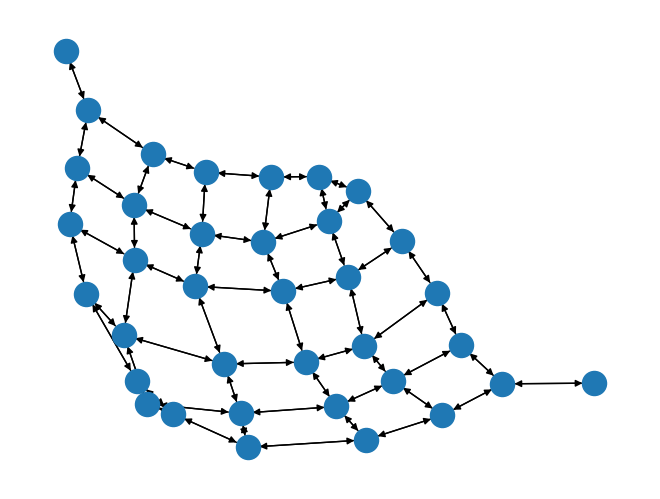

In [160]:
data23 = np.array(data(23, list))

def gen_graph(data, slope_flag=True):
    ymax, xmax = data.shape
    graph = nx.DiGraph(nx.grid_graph((xmax, ymax)))
    slopes = {'^': (0, -1), '>': (1, 0), 'v': (0, 1), '<': (-1, 0)}

    for j, row in enumerate(data):
        for i, v in enumerate(row):
            if v == '#':
                graph.remove_node((i, j))
            elif slope_flag and (slope := slopes.get(v)):
                # print('here', (i, j))
                slopex, slopey = abs(slope[0]), abs(slope[1])
                if (i+slopey, j+slopex) in graph:
                    graph.remove_edge((i, j), (i+slopey, j+slopex))
                if (i-slopey, j-slopex) in graph:
                    graph.remove_edge((i, j), (i-slopey, j-slopex))
                graph.remove_edge((i, j), (i-slopex, j-slopey))
    nx.set_edge_attributes(graph, 1, 'weight')

    for node in list(graph):
        neighbors = list(graph.neighbors(node))
        # print(node, neighbors, graph.edges(node))
        if len(neighbors) == 2:
            new_weight = sum(graph.edges[node, neigh].get('weight', 1) for neigh in neighbors)
            graph.add_edge(*neighbors, weight=new_weight)
            graph.add_edge(neighbors[1], neighbors[0], weight=new_weight)
            graph.remove_node(node)
    
    print('nodes', len(graph.nodes))
    print('edges', len(graph.edges))

    return graph


def day23(data, slope_flag=True):
    graph = gen_graph(data, slope_flag)
    nx.draw(graph)    
    return max(nx.path_weight(graph, path, 'weight') for path in nx.all_simple_paths(graph,  (np.where(data[0] == '.')[0][0], 0), (np.where(data[-1] == '.')[0][0], len(data)-1)))

# day23(data23)
day23(data23, False)

KeyboardInterrupt: 

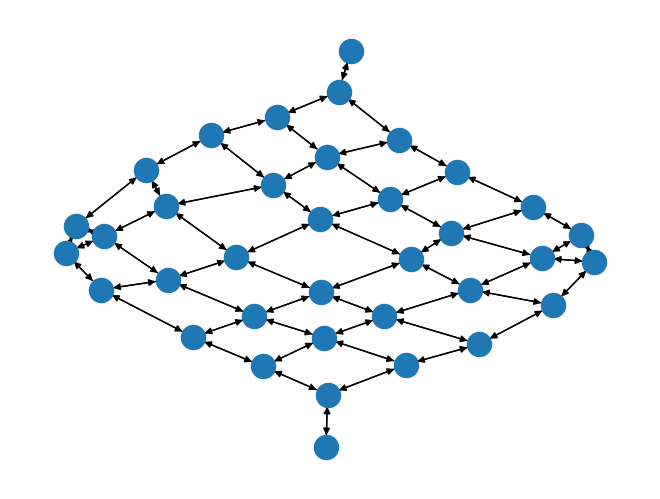

In [132]:
day23(data23, False)

In [37]:
def bfs(nodes, start, get_neighbors, end_condition=lambda _: False):
    q = deque([(start, [])])
    longest = []

    while q:
        current, visited = q.pop()
        visited.append(current)
        if end_condition(current):
            # print(visited)
            if len(visited) > len(longest):
                longest = visited
        neighbors = list(get_neighbors(nodes, current))
        for node in neighbors:
            if node in visited:
                continue
            q.append((node, visited.copy()))
    return longest

def day23(data, slope_flag=True):
    start = np.where(data[0] == '.')[0][0]
    ymax, xmax = data.shape
    slopes = {'^': -1j, '>': 1, 'v': 1j, '<': -1}

    def get_neighbors(nodes, current):
        y, x = int(current.imag), int(current.real)
        if slope_flag and nodes[y, x] in slopes:
            yield current + slopes[nodes[y, x]]
        else:
            for i in slopes.values():
                candidate = current + i
                newy, newx = int(candidate.imag), int(candidate.real)
                if newy >= 0 and newy < ymax and newx >= 0 and newx < xmax:
                    new = nodes[newy, newx]
                    if new != '#' and (not slope_flag or slopes.get(new, 0) != -i):
                        yield candidate

    visited = bfs(data, start, get_neighbors, lambda x: int(x.imag) == ymax-1)
    return visited         
    
# visited = day23(data23)

def visualize(arr, vmap):
    visual = arr.copy()
    for i in vmap:
        y, x = int(i.imag), int(i.real)
        visual[y, x] = 'O'
    print(visual)

# len(visited)-1

In [38]:
visited = day23(data23, False)
print(len(visited)-1)

KeyboardInterrupt: 